# Implementação do Encoder e Decoder Determinístico de Ação


Seguindo o modelo conceitual definido pela arquitetura, em que o World Model opera com pares instantâneos `(St​,at​)`, este notebook irá construir e testar a arquitetura básica de codificação de uma única ação em um instante de tempo `t`. O modelo do enconder traduz o objeto JSON que representa a ação da simulação em um vetor latente compacto `za` e o decoder o reconstrói, a fim de testar a corretude do encoder.

Cada ação tem:
- `time`: timestamp em segundos
- `type`: tipo de ação (mouse_down)
- `object`: objeto afetado (ball)
- `pos`: [x, y] coordenadas da ação

Note que o encoder não codifica o campo `time`, assume-se que a ação e o frame estarão casados temporalmente na etapa do WFM

## 1. Dependências

In [18]:
# Importações necessárias
import torch
import torch.nn as nn
import numpy as np
import json
import random
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Garante a reprodutibilidade
torch.manual_seed(42)

## 2. Definições do Cenário e Codificação

A primeira etapa consiste em codificar uma ação em um tensor do Pytorch. A ausência de ação corresponde à um tensor nulo.

In [20]:
# Dimensões da tela do cenário 1
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 600

# Codificação One-Hot
TYPE_ENCODING = {
    'mouse_down': [1.0],  # Ação presente
    'none':  [0.0]        # Ação ausente
}

OBJECT_ENCODING = {
    'ball': [1.0], # Cenário 1 só tem bolas
    'none': [0.0]  # Falta de ação, 0 para que o vetor final da falta de ação seja nulo
}

# Dimensão do vetor de entrada: [type(1)] + [object(1)] + [x_norm(1)] + [y_norm(1)]
INPUT_VECTOR_DIM = 4

LATENT_ACTION_DIM = 16 # Za: Dimensão do Espaço Latente da Ação

In [21]:
# Função de codificação
def encoding_function(action_data: dict = None) -> torch.Tensor:
  """
    Converte um dicionário de ação ou um sinal de 'ausência de ação' em um tensor

    Args:
        action_data: Dicionário de ação (JSON) ou None na ausência dela

    Returns:
        Um tensor PyTorch de dimensão [INPUT_VECTOR_DIM]
  """

  # Caso de ausencia de ação
  if action_data is None:
    type_vector = TYPE_ENCODING['none']
    object_vector = OBJECT_ENCODING['none']
    x_norm = 0.0
    y_norm = 0.0

  # Ação positiva (mouse_down)
  elif action_data:
    type_vector = TYPE_ENCODING['mouse_down']
    object_vector = OBJECT_ENCODING.get(action_data['object'], [0.0]) # Pega o vetor da ball
    pos_x = action_data['pos'][0]
    pos_y = action_data['pos'][1]

    # Normaliza as coordenadas da tela para o intervalo [0, 1]
    x_norm = pos_x / SCREEN_WIDTH
    y_norm = pos_y / SCREEN_HEIGHT

  input_list = type_vector + object_vector + [x_norm, y_norm]

  if len(input_list) != INPUT_VECTOR_DIM:
    raise ValueError(f"Dimensão do vetor inválida: {len(input_list)}")

  return torch.tensor(input_list, dtype=torch.float32)

In [22]:
# Exemplo de ação mouse_down
exemplo_acao = {
    "time": 9.40,
    "type": "mouse_down",
    "object": "ball",
    "pos": [400, 300]
}

# Testando codificação de ação presente
vetor_acao = encoding_function(exemplo_acao)
print("Ação presente (mouse_down):", vetor_acao.tolist())

# Testando codificação de ausência de ação (No-Op)
vetor_none = encoding_function(None)
print("Ausência de ação:", vetor_none.tolist())


Ação presente (mouse_down): [1.0, 1.0, 0.5, 0.5]
Ausência de ação: [0.0, 0.0, 0.0, 0.0]


## 3. Criando o Encoder e Decoder

Agora vamos criar uma rede neural simples que transforma esses 4 features em um embedding mais rico. Depois, vamos fazer o mesmo só que para o movimento contrário. Optou-se por uma rede simples inicialmente, para fins de teste.

In [23]:
class TextEncoder(nn.Module):
  """
  Encoder determinístico (embedding)
  Mapeia o vetor de entrada para o espaço latente de 16 dimensões
  """

  def __init__(self, input_dim=INPUT_VECTOR_DIM, latent_dim=LATENT_ACTION_DIM):
    super().__init__()

    self.latent_dim = latent_dim

    self.net = nn.Sequential(
      nn.Linear(input_dim, 16),
      nn.ReLU(),
      nn.Linear(16, latent_dim)
    )

  def forward(self, x):
    return self.net(x)

In [24]:
class TextDecoder(nn.Module):
  """
  Decoder determinístico (reconstrução)
  Mapeia o vetor latente de volta para o espaço da ação original
  """

  def __init__(self, latent_dim=LATENT_ACTION_DIM, output_dim=INPUT_VECTOR_DIM):
    super().__init__()

    self.net = nn.Sequential(
      nn.Linear(latent_dim, 16),
      nn.ReLU(),
      nn.Linear(16, output_dim)
    )

  def forward(self, z):
    x = self.net(z)
    return torch.sigmoid(x)


class TextDecoder(nn.Module):
  """
  Decoder determinístico (reconstrução)
  Mapeia o vetor latente de volta para o espaço da ação original
  """

  def __init__(self, latent_dim=LATENT_ACTION_DIM, output_dim=INPUT_VECTOR_DIM):
    super().__init__()

    self.net = nn.Sequential(
      nn.Linear(latent_dim, 32),
      nn.ReLU(),
      nn.Linear(32, 16),
      nn.ReLU(),
      nn.Linear(16, output_dim)
    )

  def forward(self, z):
    return self.net(z)


## 4. Geração de um dataset sintético simples

Como a estrutura das ações é muito simples, é mais vantajoso montar um dataset sintético com mais ações do que usar o dataset real com as 200 simulações. Note que na simulação real, menos de 1% dos frames terão uma ação correspondente. Mesmo assim, opta-se por fazer um split de 50/50 em dados com ação positiva e nula. Isso se deve principalmente porque caso a divisão que espelha o comportamento real fosse usada, o modelo não teria incentivos para minimizar a perda das ações com clique, e focaria apenas em minimizar ao máximo o erro da ausência de ação, ignorando o outro caso.

In [25]:
NUM_SAMPLES = 2000
BATCH_SIZE = 64

synthetic_inputs = []

# Gerar amostras de clique
for _ in range(1000): # 50% de 2000

  pos_x = random.randint(50, 750)
  pos_y = random.randint(50, 500)

  # Monta a estrutura de dados
  action_data = {
    "type": "mouse_down",
    "object": "ball",
    "pos": [pos_x, pos_y]
  }

  # Codifica e armazena
  synthetic_inputs.append(encoding_function(action_data))


# Gerar amostras de Ausência de Ação
for _ in range(1000): # 50% de 2000
  # Quando não tem ação, passa um None à função de encoding
  synthetic_inputs.append(encoding_function(None))

In [26]:
full_tensor = torch.stack(synthetic_inputs)

# Note que como queremos reconstruir a entrada, ela é a mesma coisa que a saída
dataset = TensorDataset(full_tensor, full_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataset Sintético Gerado: {len(full_tensor)} amostras.")
print(f"Shape de um Batch: {next(iter(dataloader))[0].shape}")

Dataset Sintético Gerado: 2000 amostras.
Shape de um Batch: torch.Size([64, 4])


## 5. Treinamento e validação

O treinamento e validação são realizados nas células abaixo

In [27]:
# Iniciação dos modelos e otimizador
text_encoder = TextEncoder()
text_decoder = TextDecoder()

# Vamos combinar os parâmetros dos dois modelos em uma única lista de parâmetros e otimizá-los de uma vez
params = list(text_encoder.parameters()) + list(text_decoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)

# Função de Perda é a MSE
loss_function = nn.MSELoss()

#### Construindo a base de dados para validação

Para a validação, definiu-se que 20% do dataset estaria destinado para a validação dos resultados, enquanto que os restantes 80% estariam dedicados para o treinamento do modelo.

In [ ]:
### Separando dados para validação
from torch.utils.data import random_split,DataLoader

##Definindo-se os tamanhos de cada dataset
VAL_RATIO = 0.2 # 20% é destinado para validação
val_size = int(len(dataset) * VAL_RATIO) #Calculado o tamanho do dataset de validação
train_size = len(dataset) -val_size #Calculado o tamanho de dataset de treinamento

train_dataset, val_dataset = random_split(dataset,[train_size,val_size])  #random_split é executado no dataset a fim de criar cada um dos datasets
#para a respectivo propósito através do random_split

train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True) #Train_dataloader é incializado chamando-se o DataLoader do pytorch e passando o dataset adequado
val_dataloader = DataLoader(val_dataset,batch_size=32,shuffle=False)



In [ ]:
NUM_EPOCHS = 20
print("Iniciando treinamento")

train_losses = [] # Perdas de treinamento para plotar depois
val_losses = [] # Perdas de validação que serão usadas para plotar depois os resultados

for epoch in range(NUM_EPOCHS):
    #Treinamento
    text_decoder.train()
    text_decoder.train()
    total_loss = 0  # Acumula a perda total de cada época

    # Loop dos batches
    for data, _ in dataloader:
        optimizer.zero_grad()

        # Forward pass, codifica na representação latente
        z_a = text_encoder(data)

        # Forward pass, decodifica a representação latente
        reconstruction = text_decoder(z_a)

        # Calcula a perda entre a reconstrução e os dados originais
        loss = loss_function(reconstruction, data)

        loss.backward()  # Backpropagation
        optimizer.step()  # Atualiza os pesos do modelo com base nos gradientes

        total_loss += loss.item()

    avg_train_loss = total_loss/ len(train_dataloader)
    #avg_loss = total_loss / len(dataloader)
    train_losses.append(avg_train_loss)

    #Iniciada a validação do treinamento
    #Validação
    text_encoder.eval()
    text_decoder.eval()
    val_loss_total = 0

    with torch.no_grad():
        for data,_ in val_dataloader:
            z_a = text_encoder(data)
            reconstruction = text_decoder(z_a)
            val_loss = loss_function(reconstruction,data)
            val_loss_total += val_loss.item()

    avg_val_loss = val_loss_total / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Mostra a perda a cada 5 épocas
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss de Reconstrução: {avg_train_loss:.6f}")
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

Iniciando treinamento
Epoch [5/20], Loss de Reconstrução: 0.008366
Epoch [5/20] | Train Loss: 0.008366 | Val Loss: 0.012960
Epoch [10/20], Loss de Reconstrução: 0.006950
Epoch [10/20] | Train Loss: 0.006950 | Val Loss: 0.011041
Epoch [15/20], Loss de Reconstrução: 0.005209
Epoch [15/20] | Train Loss: 0.005209 | Val Loss: 0.007972
Epoch [20/20], Loss de Reconstrução: 0.003146
Epoch [20/20] | Train Loss: 0.003146 | Val Loss: 0.004664


## Plotagem dos resultados de treinamento e validação
Uma vez que o modelo tenha sido devidamente treinado e validado, faz-se importante realizar a representação visual dos dados ao longo do tempo, de tal maneira a representar assim as percas obtidas ao longo do tempo.
A imagem abaixo representa as perdas totais de validação e treinamento.

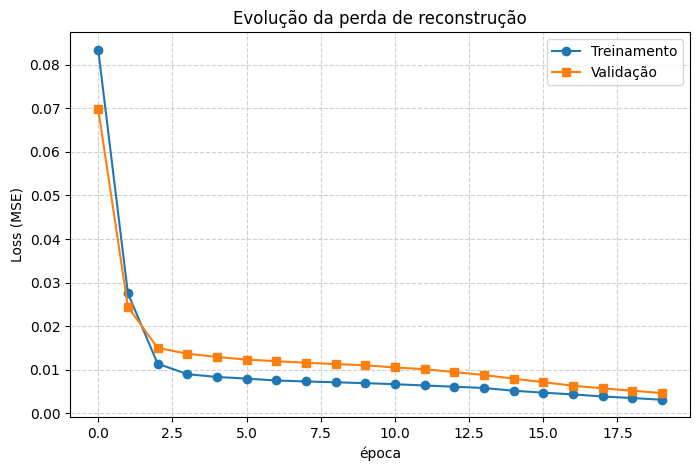

In [34]:
plt.figure(figsize=(8,5))
plt.plot(train_losses,label="Treinamento",marker='o')
plt.plot(val_losses,label="Validação",marker='s')
plt.title("Evolução da perda de reconstrução")
plt.xlabel("época")
plt.ylabel("Loss (MSE)")
plt.grid(True,linestyle='--',alpha=0.6)
plt.legend()
plt.show()

É possível observar através da imagem que o gráfico está caindo constantemente e que não apresenta indícios de overfitting

## Feedbacks adicionais quanto ao treinamento

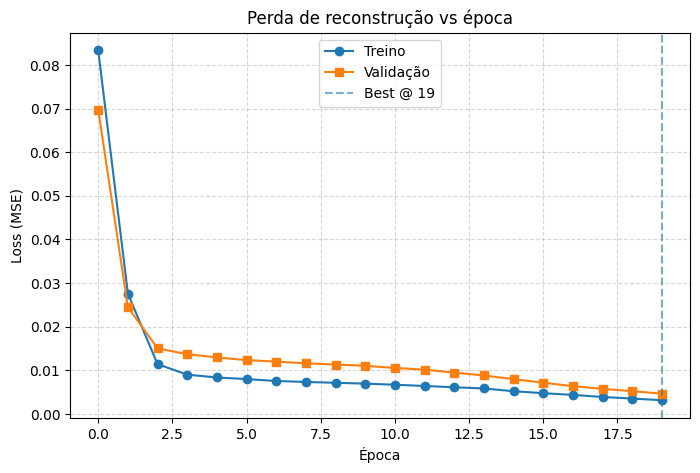

In [35]:
best_epoch = int(np.argmin(val_losses))
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Treino", marker='o')
plt.plot(val_losses, label="Validação", marker='s')
plt.axvline(best_epoch, linestyle='--', alpha=0.6, label=f"Best @ {best_epoch}")
plt.title("Perda de reconstrução vs época")
plt.xlabel("Época"); plt.ylabel("Loss (MSE)"); plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.show()


### Exportação de métricas por época (CSV)

In [39]:
import pandas as pd
history = pd.DataFrame({"epoch":list(range(1,len(train_losses)+1)),
                        "train_loss": train_losses, "val_loss":val_losses})
history.to_csv("training_history.csv",index=False)
print("Valores salvos em training_history.csv")

Valores salvos em training_history.csv


### Erro por dimensão (quais campos erram mais?)

MAE => Mean Absolute Error (erro médio de reconstrução em cada campo do vetor de entrada)

[type, object, x , y]
tipo de ação,
object => objeto afetado,
x => Posição x,
y => Posição y;


In [41]:
import torch
text_encoder.eval(); text_decoder.eval()
per_dim_mae = torch.zeros(data.shape[1])
n = 0
with torch.no_grad():
    for data, _ in val_dataloader:
        rec = text_decoder(text_encoder(data))
        per_dim_mae += (rec - data).abs().mean(dim=0)
        n += 1
per_dim_mae /= n
print("MAE por dimensão:", per_dim_mae.detach().cpu().numpy())


MAE por dimensão: [0.02663636 0.04098256 0.05402165 0.0424518 ]
